### flask 서버로 post 요청해서 테스트

In [271]:
import requests
data = {},
response = requests.post('post_url', json=data)
print(response.json())

[['쭈앤쭈 광흥창역점', '서울 마포구 창전동', 100.0], ['나이스샐러드', '서울 마포구 도화동', 100.0], ['산동만두', '서울 마포구 도화동', 98.11320754716981], ['레이지수잔', '서울 용산구 용문동', 97.2972972972973], ['마포왕족발', '서울 마포구 공덕동', 96.3157894736842], ['종로수제비 공덕점', '서울 마포구 공덕동', 96.20253164556962], ['후라토식당 여의도직영점', '서울 영등포구 여의도동', 95.5249569707401], ['부영각', '서울 마포구 용강동', 93.58974358974359], ['밤노을', '서울 용산구 한강로3가', 92.5925925925926], ['권서방네순대 여의도점', '서울 영등포구 여의도동', 92.5], ['써브웨이 공덕역롯데캐슬점', '서울 마포구 공덕동', 91.37931034482759], ['카페마마스 여의도점', '서울 영등포구 여의도동', 89.21568627450979]]


### step1. 공통 중심 위치 - 원 안에 들어있는 식당 찾기

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import faiss, math, copy, itertools, random, pickle, string
from collections import Counter
import pandas as pd
import itertools

In [188]:
def find_combinations(lst, num):
    # 리스트에서 3개 요소의 모든 조합을 찾음
    return list(itertools.combinations(lst, num))

def get_circumcenter(points, eps):
    # return : tuple (원 중심, 원 반지름)
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    x = (x1**2*y2 - x1**2*y3 - x2**2*y1 + x2**2*y3 + x3**2*y1 - x3**2*y2 + y1**2*y2 - y1**2*y3 - y2**2*y1 + y2**2*y3 + y3**2*y1 - y3**2*y2)
    x /=  2*x1*y2 - 2*x1*y3 - (2*x2*y1 - 2*x2*y3) + 2*x3*y1 - 2*x3*y2

    y = -(x1**2*x2 - x1**2*x3 - x2**2*x1 + x2**2*x3 + x3**2*x1 - x3**2*x2 + y1**2*x2 - y1**2*x3 - y2**2*x1 + y2**2*x3 + y3**2*x1 - y3**2*x2)
    y /=  2*x1*y2 - 2*x1*y3 - (2*x2*y1 - 2*x2*y3) + 2*x3*y1 - 2*x3*y2
    return np.array([x, y]), np.sqrt((x1-x)**2 + (y1-y)**2) + eps

def get_center_radius(points): 
    # return : tuple (원 중심, 원 반지름)
    p1, p2, p3 = np.array(points[0]), np.array(points[1]), np.array(points[2])
    d1, d2, d3 = np.linalg.norm(p1 - p2), np.linalg.norm(p2 - p3), np.linalg.norm(p3 - p1)
    eps = (d1 + d2 + d3)/3 * 5e-2
    sorted = np.sort([d1, d2, d3])
    if sorted[0] **2 + sorted[1]**2 < sorted[2]**2:
        return (p2 + p3)/2, sorted[2]/2 + eps
    else:
        return get_circumcenter(points, eps)

def circle_score(points, target_p, radius):
    dist_vector = np.linalg.norm(points - target_p, axis=1)
    insiders = (dist_vector < radius).sum()
    return [insiders / radius**2, insiders]

def pick_circle_index(score_list, num, min_contain_thold):
    candidates = [x[0] if x[1] >= num * min_contain_thold else 0 for x in score_list]
    return np.argmax(candidates)

def get_outsiders(points, target_p, radius):
    dist_vector = np.linalg.norm(points - target_p, axis=1)
    return [x for i, x in enumerate(points) if dist_vector[i] > radius]

def get_circles(data, min_contain_thold, min_score_decay_thold, min_elem_decay_thold):
    # min_contain_thold : 처음 원 찾을 때 전체 포인트의 몇 퍼센트를 포함시킬 것이냐 + outsider중 다음 원에 포함될 최소 퍼센트 비율
    # min_score_decay_thold : 다음 원 찾을 때 점수를 얼마나 decay 허용할 것인지 비율
    # min_elem_decay_thold : 다음 원 찾을 때 포함되는 포인트 수를 얼마나 decay 허용할 것인지 비율 (이전 원의 몇 퍼센트만 있어도 되나)
    pred_score = 0
    pred_inners = 0
    treasures = []
    left_data = copy.deepcopy(data)
    while len(left_data) >= 3:
        scores = []
        combs = find_combinations(left_data, 3)
        for x in combs:
            x1, x2, x3 = x
            if x1==x2 or x2==x3 or x3==x1:
                continue
            scores.append(circle_score(left_data, *get_center_radius(x)))
        pick_thold = min_contain_thold if pred_score == 0 else pred_inners * min_elem_decay_thold/len(left_data)
        picked_index = pick_circle_index(scores, len(left_data), pick_thold)
        if scores[picked_index][0] > pred_score * min_score_decay_thold and scores[picked_index][1] > pred_inners * min_elem_decay_thold:
            pred_score, pred_inners = scores[picked_index][0], scores[picked_index][1]
            treasures.append(get_center_radius(combs[picked_index]))
            left_data = get_outsiders(left_data, *get_center_radius(combs[picked_index]))
        else:
            break
    return treasures

In [2]:
with open('../naver_ppd_4.pkl', 'rb') as f:
    df = pickle.load(f)

In [209]:
from google.cloud import firestore
from google.cloud import firestore
from google.oauth2 import service_account

# 서비스 계정 키 파일을 사용하여 인증
credentials = service_account.Credentials.from_service_account_file('serviceAccountKey.json')
db = firestore.Client(credentials=credentials)

specific_place = dict()
num_of_choice_each = []
for ID in user_choice:
    tmp_place = []
    doc_ref = db.collection('Users').document(ID)
    # 문서 가져오기
    doc = doc_ref.get()
    if doc.exists:
        # 'markRests' 필드 값 가져오기
        for chosen in user_choice[ID]:
            mark_rests = doc.to_dict().get('markRests')
            tmp_place += mark_rests[chosen]
    else:
        print('문서가 존재하지 않습니다.')
    specific_place[ID] = tmp_place
    num_of_choice_each.append(len(tmp_place))

In [3]:
with open('obj_key2ind.pickle', 'rb') as f:
    obj_key2ind = pickle.load(f)

# of user input : 35


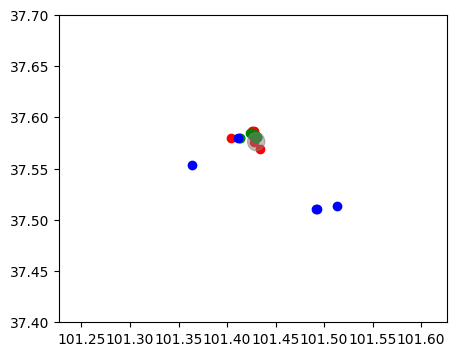

In [ ]:
user_input_obj_key = [item for sublist in specific_place.values() for item in sublist]  
user_input_ind = [obj_key2ind[x] for x in user_input_obj_key] 

print('# of user input :', len(user_input_obj_key))

user_loc = [[float(df[elem]['geolocation'][1]), float(df[elem]['geolocation'][2])] for elem in user_input_ind]
normalized_loc = [[elem[0]*math.cos(math.radians(37)), elem[1]] for elem in user_loc]
treasures = get_circles(normalized_loc, 1/len(user_choice), 0.75, 0.5)

fig, ax = plt.subplots(figsize=(5,5 * math.cos(math.radians(37))))
ax.scatter([x[0] for x in normalized_loc][:15], [x[1] for x in normalized_loc][:15], color='r')
ax.scatter([x[0] for x in normalized_loc][15:30], [x[1] for x in normalized_loc][15:30], color='g')
ax.scatter([x[0] for x in normalized_loc][30:45], [x[1] for x in normalized_loc][30:45], color='b')
ax.scatter([x[0] for x in normalized_loc][45:], [x[1] for x in normalized_loc][45:], color='y')
circles = []
for i, elem in enumerate(treasures):
    circles.append(Circle(elem[0], elem[1], fill=True, alpha=0.5 * 0.8**i, color='grey'))
    ax.add_patch(circles[-1])
    
ax.set_ylim(37.4, 37.7)
ax.set_xlim(126.75 * math.cos(math.radians(37)), 127.25* math.cos(math.radians(37)))
plt.show()

In [ ]:
df_loc = [[float(elem['geolocation'][1])*math.cos(math.radians(37)), float(elem['geolocation'][2])] for elem in df]
obj_key = [elem['obj_key'] for elem in df]  #여기서 바로 title 안 찾는 이유는 title이 겹칠수도 있으니.
menu_squeeze = [elem['menu_squeeze'] for elem in df]  ### 메뉴가 없으면 제외시키기 위함

satisfied_loc_cond = []
rcen_list = []
for center in treasures:
    x_cen, y_cen = center[0]
    r_cen = center[1]
    rcen_list.append(r_cen)
    for ind, coord in enumerate(df_loc):
        x_coord, y_coord = coord
        if ((x_coord-x_cen)*math.cos(math.radians(y_cen)))**2+(y_coord-y_cen)**2 <= r_cen**2:
            if len(menu_squeeze[ind])!=0:   ### 메뉴가 없으면 제외시킴
                satisfied_loc_cond.append(obj_key[ind])
satisfied_loc_cond = np.unique(satisfied_loc_cond)

In [191]:
len(satisfied_loc_cond)

1521

In [192]:
sum_ = 0
for r_cen in rcen_list:
    print(r_cen, r_cen * 110.574, r_cen*111.32*math.cos(math.radians(y_cen)))
#     sum_ += ((r_cen*111.32*math.cos(math.radians(y_cen)))**2 * math.pi+(r_cen * 110.574)**2*math.pi)/2
    sum_ += (r_cen*111.32*math.cos(math.radians(y_cen)))**2 * math.pi
print(sum_/600)

0.008854542212939815 0.979082150653607 0.781199216365426
0.003195377848959778


In [4]:
with open('have_a_meal_module/positive_top5.pkl', 'rb') as f:
    positive_top5 = pickle.load(f)

In [5]:
with open('have_a_meal_module/long_bads_1106.pkl', 'rb') as f:
    long_bads_1106 = pickle.load(f)
long_bads = long_bads_1106[long_bads_1106['updated_pred_label']==0].copy()

In [7]:
with open('have_a_meal_module/obj_key2ind.pkl', 'rb') as f:
    obj_key2ind = pickle.load(f)
obj_list = [x for x in obj_key2ind]
len(obj_list)

127399

In [16]:
with open('posneg_ratio_dict_title_key.pkl', 'rb') as f:
    ratio_dict = pickle.load(f)

In [194]:
## obj_key로 title찾기 
popul_ind = [obj_key2ind[x] for x in satisfied_loc_cond]
popul_title = [df[i]['title'] for i in popul_ind]

In [195]:
## 찾은 title로 긍부정 비율 값 얻기
popul_posneg = []
popul_posneg_ind = []
error_ind = []
for key_ind, keyword in enumerate(popul_title):
    try:
        pn_ratio = ratio_dict[keyword]
        if pn_ratio > 85:
            popul_posneg.append(pn_ratio)
            popul_posneg_ind.append(key_ind)
    except Exception as e:
        print(keyword)
        error_ind.append(key_ind)

##### 긍부정리뷰 dict로 만들어놓기

In [ ]:
### obj_key를 키로 한 긍부정리뷰 dict
# from tqdm.notebook import tqdm
# posneg = {}
# for x in tqdm(obj_list):
#     tmp = long_bads[long_bads['obj_key']==x].copy()
#     try:
#        ratio = 1 - tmp[tmp['updated_pred_label']==0].shape[0] / positive_top5[positive_top5['obj_key']==x]['total_review_counts'].iloc[0]
#     except:
#         ratio = np.NaN
#     posneg[x] = ratio

  0%|          | 0/127399 [00:00<?, ?it/s]

In [ ]:
# with open('posneg_ratio_dict.pkl', 'wb') as f:
#     pickle.dump(posneg, f)

In [197]:
### title 기준으로 해서 겹치는 가게명이면 덮어씌워짐
# from tqdm.notebook import tqdm
# ratio_dict = {}
# for x in tqdm(df):
#     keyword = x['title']
#     tmp = long_bads[long_bads['title']==keyword].copy()  ## tmp : 해당 식당의 나쁜 리뷰만 모아져있음
#     tmp_total = pos[pos['title']==keyword].copy()    ## tmp_total : 해당 식당의 모든 리뷰가 모아져있음
#     try:
#         pn_ratio = (1 - tmp[tmp['updated_pred_label']==0].shape[0] / tmp_total['total_review_counts'].iloc[0]) * 100
#     except:  # 리뷰가 없는 애들
#         pn_ratio = np.NaN
#     ratio_dict[keyword] = pn_ratio

# import pickle
# with open('posneg_ratio_dict.pkl', 'wb') as f:
#     pickle.dump(ratio_dict,f)

In [198]:
### 긍부정비율 값이 존재하는 가게수와 전체 가게 127000개에서의 비율
len([x for x in ratio_dict.values() if not np.isnan(x)]), len([x for x in ratio_dict.values() if not np.isnan(x)]) / len(ratio_dict)

(94997, 0.8183470590262224)

In [199]:
## 긍부정 비율값 index를 satisfied_loc_cond(위치 조건 만족 리스트)의 index에 매칭
satisfied_db_indexing = [popul_ind[i] for i in popul_posneg_ind]

In [200]:
len(satisfied_db_indexing)

1303

### step2. 메뉴 임베딩 벡터 유사도 서치 - 거점 후보군 뽑기

In [201]:
embed_sample = []
for i in range(len(df)):
    embed_sample.append('/'.join(''.join(''.join(''.join('/'.join([x[0] for x in df[i]['menu_squeeze']]).split('popularrepresentation')).split('representation')).split('popular')).lower().split('n/')).strip())
with open('ada-embedded_multi.pkl', 'rb') as f:
    embedded = pickle.load(f)
embedded = np.array(embedded)
embedded_pd = pd.DataFrame(embedded)
with open('ada-embedded_multi_ind.pkl', 'rb') as f:
    embedded_ind = pickle.load(f)

In [202]:
def indexing(item, embedded_ind=embedded_ind):
    ### item :  원래 df3 인덱스 
    ### return: 멀티프로세스로 돌린 임베딩 결과의 인덱스 
    return embedded_ind[item]
def indexvec2distmat_l2(data, index_vector, target_vector):
    candidate_mat = data[index_vector]
    target_mat = data[target_vector]
    return np.sqrt(((candidate_mat[:, np.newaxis] - target_mat)**2).sum(axis=2))
def costfunc_min(mat, to_df_ind, num_of_choice_each):
    iterator = iter(to_df_ind)
    split_lists = []
    for size in num_of_choice_each:
        split_lists.append(list(islice(iterator, size)))
    x0 = 0
    sub_min_ind = []
    for x in num_of_choice_each:
        kth_min = min(5, x)
        sub_min_ind += np.argpartition(mat.min(0)[x0:x0+x], kth_min-1)[:kth_min].tolist()
        x0=x
    return mat[:, sub_min_ind].min(0).sum()


In [203]:
faiss_db = [embedded[indexing(j)] for j in satisfied_db_indexing]
# faiss_db_ind = [indexing(j) for j in satisfied_db_indexing]
# df 인덱스 -> faiss 인덱스. faiss_db_ind의 인덱스는 satisfied_db_indexing 순서대로. 값은 faiss인덱스. faiss의 인덱스로 할 게 없긴함

In [204]:
###### 데이터셋 생성 (예시)
d = embedded_pd.shape[1]  # 벡터의 차원
nb = embedded_pd.shape[0]  # 데이터베이스 크기
np.random.seed(18)
db_vectors = np.array(faiss_db).astype('float32')

# 인덱스 생성
index11 = faiss.IndexFlatL2(d)  # L2을 사용한 인덱스 생성
index11.add(db_vectors)

In [205]:
k = 5  # 찾고자 하는 이웃의 수
query_vectors = np.array([embedded[indexing(x)] for x in user_input_ind]).astype('float32')

## D : (user_input개수, k) l2거리
## I : (user_input개수, k) db_vectors에서의 인덱스
D, I = index11.search(query_vectors, k)

In [206]:
I    # db_vector에서 몇 번째인지 인덱스

array([[ 749,  959,  237,  701,   77],
       [ 867,  719,  388, 1290,  657],
       [ 584, 1273, 1061,  815,  278],
       [ 227,  710,  977,  317, 1159],
       [   6, 1165,  795,  549,  203],
       [ 187,  701,  237,  548,  239],
       [ 663,  292, 1017,  589,   18],
       [ 701,  436,  218,  977,  564],
       [1046,  716,  365, 1078,  701],
       [  94,  209,  322,  411,  431],
       [ 766,  487,  603,  482,  221],
       [ 283,  241,  334,  326,  557],
       [ 865, 1184,  109,   83,  914],
       [ 376,  321,  211,  877,  711],
       [   8,  701,  828,  355,  696],
       [1199, 1292,   94,  209,  322],
       [1248, 1281, 1190,  600,  975],
       [ 372, 1012, 1121, 1144, 1298],
       [ 892,  628,  915,  862,  381],
       [ 372, 1012, 1121, 1144, 1298],
       [  27,   22,  570, 1228, 1149],
       [ 771,  578, 1192,  144,  944],
       [ 638,  228,  554,  225,   75],
       [1284,  280, 1291,  428,  819],
       [  78,  171,  290,  306,  417],
       [ 796,  223,  524,

In [207]:
faiss_res_in_df_ind = [satisfied_db_indexing[x] for x in I.reshape(-1)]
faiss_res_in_df_ind = np.unique(faiss_res_in_df_ind)

### step3. 거점 후보군<->유저input 간 최소거리 합의 최소화 조합 찾기

In [221]:
%%time
I_in_df_ind = np.array([satisfied_db_indexing[x] for x in I[:,0]])
distmat = indexvec2distmat_l2(embedded, faiss_res_in_df_ind, I_in_df_ind)
min_inds = []
min_value = 100000
target_num = 20

if len(faiss_res_in_df_ind)<=30:
    numbers = np.arange(len(faiss_res_in_df_ind))
    combinations = list(itertools.combinations(numbers, target_num))
    random.shuffle(combinations)
else:
    num_samples = 100000
    combinations = [np.random.choice(len(faiss_res_in_df_ind), target_num, replace=False) for _ in range(num_samples)]
    
for i in range(min(100000, len(combinations))):
    random_integers = [x for x in combinations[i]]
    sim_mat = distmat[random_integers]    
    if costfunc_min(sim_mat, I_in_df_ind, num_of_choice_each) < min_value:
        print(min_value)
        min_inds = random_integers
        min_value = costfunc_min(sim_mat, I_in_df_ind, num_of_choice_each)
output_inds = np.array(faiss_res_in_df_ind)[min_inds]

100000
3.4710878432092906
3.174024077621055
1.8661839108448002
1.4516649654117046
1.308613132249557
1.2721265502254728
0.9057906410179206
0.524172127598904
0.5240368176485025
0.3450820618154135
CPU times: user 2.31 s, sys: 172 ms, total: 2.48 s
Wall time: 2.46 s


In [56]:
for i in range(target_num):
    print(embed_sample[output_inds[i]])
    print(df[output_inds[i]]['title'], df[output_inds[i]]['category'])

연유라떼 (ice)/수제 꿀자몽에이드/아메라카노/카페라떼 (ice)/생과일쥬스
맥다방 카페,디저트
시몬스의 닭다리 바베큐/간장 치킨 크림 파스타/리코타 유령 독초 샐러드/마녀의 촛불 샐러드/훈제 연어 샐러드/트러플 알리오올리오/봉골레 파스타/레드크림 꽃게 파스타/빠네 크림 파스타/새우 로제 파스타/눈꽂치즈 토마토 파스타/매콤해물 토마토 파스타/부채살 크림 리조또/김치 칠리 라이스/부채살 토마토 리조또/새우 로제 리조또/고르곤 크럼블 피자/미이라 포테이토 피자/매콤 페퍼로니 피자/콘치즈 피자/링거칵테일
마녀주방 대학로점 이탈리아음식
부기 화이타/바비큐 포크 타코/트리플 머쉬룸 퀘사디아/부기 화이타/또띠아추가/과카몰리 추가/바비큐 포크 타코/핫 치킨 타코매운맛2단계/케이준 쉬림프 타코/바비큐 포크 퀘사디아매운맛1단계/베이컨 고르곤 퀘사디아매운맛1단계/트리플 머쉬룸 퀘사디아/핫 치킨 퀘사디아매운맛2단계/스테이크 샐러드/블루치즈 샐러드/리코타치즈&또띠아 샐러드/프렌치 프라이즈/핫 버팔로 윙매운맛3단계/치킨 포솔레매운맛1단계/과카몰리 4oz/미니 샐러드/오미자자몽 에이드/유자허니진저 에이드/피나콜라다(논알콜)/콜드브류커피/소프트드링크/하리토스/아크 허그미/아크 선데이모닝/아크 비하이/코로나/도스에끼스 라거/버니니/카스/테라 (terra)/house wine/마가리타/버니니리타/피치크러시/잭콕/진토닉, 봄베이 하이볼/데낄라선라이즈/쿠바리브레/코스모폴리탄/롱아일랜드 아이스티/피나콜라다/피나콜라다(논알콜)/모히또/모히또(논알콜)/호세쿠엘보 (shot)/호세쿠엘보 (bottle)/잭다니엘 (shot)/잭다니엘 (bottle)/봄베이 진 (shot)/봄베이 진 (bottle)/소주/쏘토닉
고부기 멕시칸그릴 대학로본점 멕시코,남미음식
수제마카롱/당근케이크/수제청(청귤청)/바스크치즈케이크/허니브레드/수제청(레몬생강)/수제청(라임청)/에이드/죠리퐁프라페
언니네다락방 카페,디저트
불고기백반/김치볶음밥/순두부찌개/돌솥비빔밥/오징어볶음/제육볶음/해물된장/참치김치찌개/김치찌개/부대찌개/삼겹

### step4. 가격median range

In [57]:
def calculate_exact_overlap_intervals(intervals):
    # Create a list of all start and end points, marking them as such
    events = []
    for start, end in intervals:
        events.append((start, 'start'))
        events.append((end, 'end'))

    # Sort the events so we process them in order
    events.sort()

    # Dictionary to store the final result and current overlap counter
    overlap_dict = {}
    current_overlap = 0
    last_point = None

    # Iterate over each event
    for point, kind in events:
        if last_point is not None and current_overlap not in overlap_dict:
            overlap_dict[current_overlap] = []
        if last_point is not None and point != last_point:
            overlap_dict[current_overlap].append((last_point, point))

        # Update overlap counter
        if kind == 'start':
            current_overlap += 1
        else:
            current_overlap -= 1

        last_point = point

    return overlap_dict

In [58]:
price_sample = []
for i in range(len(df)):
    price_sample.append(([x[1] for x in df[i]['menu_squeeze']]))
median_sample = []
# low25_sample = []
# high25_sample = []
error = []
median_index=[]
for ind, x in enumerate(price_sample):
    try:
        p = [i for i in x if type(i)!=str]
        medp = np.median(p)
        if not np.isnan(medp):
            median_sample.append(medp)
            median_index.append(ind)
#         low25_sample.append(np.quantile(p,q=0.25))
#         high25_sample.append(np.quantile(p,q=0.75))
    except: ## 가격이 empty거나 '변동'이라고만 되어있는 경우
        error.append(x)

/Users/kalvin/anaconda3/envs/python3-10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kalvin/anaconda3/envs/python3-10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [59]:
from itertools import islice
iterator = iter(user_input_ind)

split_lists = []
for size in num_of_choice_each:
    split_lists.append(list(islice(iterator, size)))


In [60]:
len(split_lists)

2

In [61]:
example = [[price_sample[x] for x in each] for each in split_lists] 
med_interval = []
for i in range(len(example)):
    med_tmp = []
    for j in example[i]:
        j_tmp = [x for x in j if x!='변동']
        if len(j_tmp)>0:
            med_tmp.append(int(np.median(j_tmp)))
    sort_med = sorted(med_tmp)
    med_interval.append((sort_med[0], sort_med[-1]))
exact_overlap_intervals = calculate_exact_overlap_intervals(med_interval)

In [62]:
exact_overlap_intervals

{1: [(3000, 7500), (21350, 40000)], 2: [(7500, 21350)]}

In [63]:
price_median_range = exact_overlap_intervals[len(exact_overlap_intervals)]

In [103]:
price_median_range

[(7500, 21350)]

In [118]:
output_median_price = [np.median([x[1] for x in df[i]['menu_squeeze'] if x[1]!='변동']) for i in output_inds]

In [176]:
satisfied_price_cond  = []
for interval in price_median_range:
    min_median = interval[0]
    max_median = interval[1]
    for ind, med_ind in enumerate(output_median_price):
        if (min_median < med_ind) & (max_median > med_ind):
            satisfied_price_cond.append([output_inds[ind], ratio_dict[df[output_inds[ind]]['obj_key']]])

In [177]:
from collections import Counter
user_input_dupl_index = [x[0] for x in Counter(user_input_ind).most_common() if x[1]>= max(len(split_lists)-1, 2)]
satisfied_price_cond += [[x,ratio_dict[df[x]['obj_key']]] for x in user_input_dupl_index]
satisfied_price_cond = np.unique(satisfied_price_cond, axis=0)

In [183]:
satisfied_price_cond[0][0]

40623

In [184]:
final_suggest_score = sorted(satisfied_price_cond, key=(lambda x: x[1]), reverse=True)
final_suggest_ind = [(df[int(x[0])]['title'],df[int(x[0])]['loc'])  for x in final_suggest_score]
print(len(final_suggest_ind))
final_suggest_ind

14


[('왕벌', '서울 종로구 종로3가'),
 ('역전할머니맥주 대학로점', '서울 종로구 명륜4가 15-1 1층'),
 ('비스트로주라 혜화점', '서울 종로구 동숭동'),
 ('명동피자 현대시티아울렛동대문점', '서울 중구 을지로6가'),
 ('신선식탁 대학로 본점', '서울 종로구 연건동'),
 ('신선식탁 대학로 본점', '서울 종로구 연건동'),
 ('본죽 동묘앞역점', '서울 종로구 숭인동'),
 ('깔리', '서울 종로구 명륜4가 171 171번지 2층'),
 ('마녀주방 대학로점', '서울 종로구 명륜2가 33-2 2층, 3층'),
 ('라화쿵부 동대문역점', '서울 종로구 창신동'),
 ('신전떡볶이 종로동대문역점', '서울 종로구 창신동'),
 ('고부기 멕시칸그릴 대학로본점', '서울 종로구 동숭동'),
 ('진아춘', '서울 종로구 명륜4가 66-2'),
 ('서울프랑스', '서울 종로구 동숭동')]